# **1. Import thư viện**

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, \
                            roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# **2. Chuẩn bị dữ liệu**

In [ ]:
df = pd.read_csv("ECommerce_Dataset_cleaned_model.csv")

In [ ]:
df.head()

,Churn,CityTier,WarehouseToHome,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,DaySinceLastOrder,CashbackAmount,DevicePerTenure
0,1,3,6,3,3,Laptop & Accessory,2,Single,9,1,11,1,5,160,0.75
1,1,1,8,3,4,Mobile Phone,3,Single,7,1,15,0,0,121,4.00
2,1,1,30,2,4,Mobile Phone,3,Single,6,1,14,0,3,120,4.00
3,1,3,15,2,4,Laptop & Accessory,5,Single,8,0,23,0,3,134,4.00
4,1,1,12,3,3,Mobile Phone,5,Single,3,0,11,1,3,130,3.00


In [ ]:
# Xác định biến đầu vào và mục tiêu
target = 'Churn'

X = df.drop(columns=[target])
y = df[target]

In [ ]:
# Xác định cột định lượng (numeric) và định tính (categorical)
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object']).columns.tolist()

# **3. Tạo Pipeline (Tiền xử lý + Mô hình)**

In [ ]:
# ColumnTransformer: One-Hot Encoding + Scaling
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), cat_cols)
    ]
)

In [ ]:
# Xây dựng model
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [ ]:
# Xây dựng Pipeline
clf = Pipeline([
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
])

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# **4. Cross validation (10-fold)**

In [ ]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

y_pred_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict')
y_proba_cv = cross_val_predict(clf, X_train, y_train, cv=skf, method='predict_proba')[:, 1]

roc_auc_cv = roc_auc_score(y_train, y_proba_cv)
print(f"CV ROC-AUC: {roc_auc_cv:.4f}")

CV ROC-AUC: 0.9156


# **5. Huấn luyện & dự đoán**

In [ ]:
# Train model
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['CityTier',
                                                   'WarehouseToHome',
                                                   'HourSpendOnApp',
                                                   'NumberOfDeviceRegistered',
                                                   'SatisfactionScore',
                                                   'NumberOfAddress',
                                                   'Complain',
                                                   'OrderAmountHikeFromlastYear',
                                                   'CouponUsed',
                                                   'DaySinceLastOrder',
                                                   'CashbackAmount',
                                                   'DevicePerTenure']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['PreferedOrderCat',
                                                   'MaritalStatus'])])),
                ('smote', SMOTE(random_state=42)),
                ('model', GradientBoostingClassifier(random_state=42))])

In [ ]:
# Dự đoán
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

In [ ]:
# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       936
           1       0.70      0.71      0.70       190

    accuracy                           0.90      1126
   macro avg       0.82      0.82      0.82      1126
weighted avg       0.90      0.90      0.90      1126



**Nhận xét:** Mô hình Gradient Boosting Classifier đạt accuracy khoảng 90% và F1-score trung bình 0.90, cho thấy mô hình có hiệu quả phân loại tổng thể khá tốt trên tập test.

- **Đối với lớp 0:** mô hình đạt **precision 0.94** và **recall 0.94**, cho thấy hầu hết khách hàng không churn được dự đoán chính xác. **F1-score 0.94** phản ánh sự cân bằng tốt giữa độ chính xác và khả năng bao phủ của lớp này, đồng thời số lượng dự đoán nhầm sang churn là tương đối thấp.

- **Đối với lớp 1:** mô hình đạt **precision 0.70** và **recall 0.71**, cho thấy mô hình có khả năng phát hiện khách hàng churn ở mức trung bình.
**F1-score 0.70** cho thấy vẫn còn một số trường hợp churn chưa được phát hiện đầy đủ, đồng thời tồn tại một lượng nhất định các dự đoán nhầm từ lớp không churn sang churn.

Nhìn chung, mô hình Gradient Boosting hoạt động tốt trong việc phân loại khách hàng không churn và đạt độ chính xác tổng thể cao. Tuy nhiên, khả năng phát hiện khách hàng churn vẫn còn hạn chế so với lớp không churn, cho thấy mô hình có xu hướng ưu tiên giảm báo động giả hơn là tối đa hóa việc phát hiện churn.

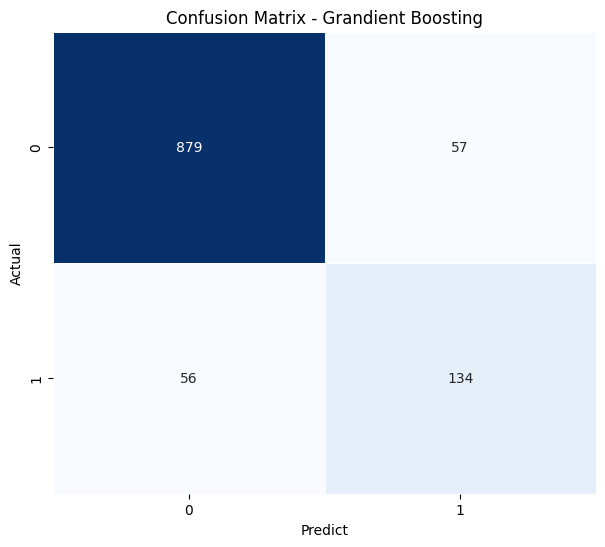

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            cbar=False, linewidths=0.5)
plt.xlabel('Predict')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Grandient Boosting')
plt.show()

**Nhận xét:**
- Mô hình dự đoán 134 khách hàng có khả năng rời bỏ giúp doanh nghiệp xác định đúng nhóm cần triển khai các chiến lược giữ chân.
- Xác định đúng 879 khách hàng trung thành, góp phần hạn chế việc tiếp cận không cần thiết và tối ưu chi phí chăm sóc khách hàng.
- Mô hình dự đoán nhầm 57 khách hàng trung thành là churn, có thể gây phát sinh chi phí chăm sóc không cần thiết.
- Mô hình vẫn chưa phát hiện được 56 khách hàng thực sự rời bỏ , đây là nhóm lỗi quan trọng do có thể dẫn đến việc bỏ sót khách hàng có nguy cơ churn.

Với tổng số lỗi là 113 trên 1126 mẫu kiểm tra, độ chính xác tổng thể đạt 89.96%, cho thấy mô hình có hiệu quả khá tốt nhưng vẫn cần cải thiện khả năng phát hiện churn.

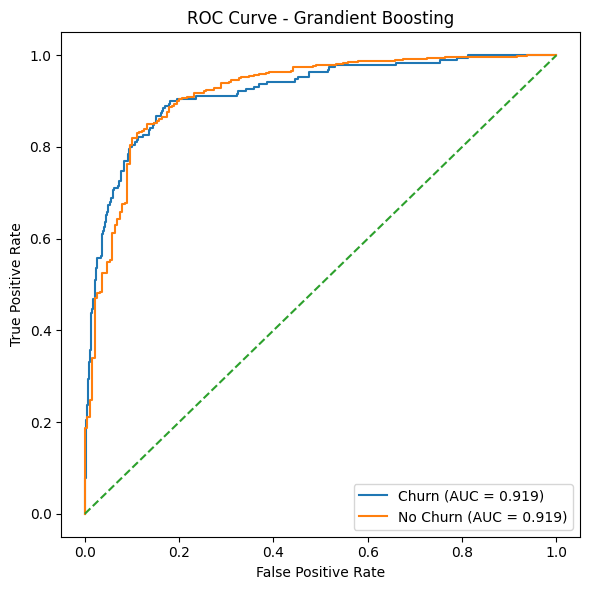

In [ ]:
# vẽ ROC Curve

# Lớp churn = 1
fpr_1, tpr_1, _ = roc_curve(y_test, y_proba[:, 1])
auc_1 = auc(fpr_1, tpr_1)

# Lớp churn = 0
fpr_0, tpr_0, _ = roc_curve(1 - y_test, y_proba[:, 0])
auc_0 = auc(fpr_0, tpr_0)

plt.figure(figsize=(6, 6))
plt.plot(fpr_1, tpr_1, label=f'Churn (AUC = {auc_1:.3f})')
plt.plot(fpr_0, tpr_0, label=f'No Churn (AUC = {auc_0:.3f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Grandient Boosting')
plt.legend()
plt.tight_layout()
plt.show()

- Diện tích dưới đường cong ROC (AUC) của mô hình SVM đạt 0.919, cho thấy mô hình có khả năng phân biệt tốt giữa khách hàng có khả năng rời bỏ và khách hàng ở lại.
- Đường cong ôm sát góc trên bên trái cho thấy cho thấy mô hình đạt được tỷ lệ phát hiện churn tương đối cao trong khi vẫn kiểm soát được tỷ lệ dự đoán nhầm. Điều này chứng tỏ mô hình có khả năng xếp hạng rủi ro churn hiệu quả, đặc biệt hữu ích trong việc lựa chọn ngưỡng dự đoán phù hợp cho các chiến lược giữ chân khách hàng.